In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")

In [81]:
df = pd.read_csv('./dane/LR_dane_treningowe_testowe.csv')
df.head(1)

,Unnamed: 0,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY,AGE_GROUP
0,0,63581743,0,16MAR39,60.0,0,11.0,67.349,0,0.0,...,1,4.461,2,0,3,0.0,18.0,0,1,5


Text(0, 0.5, 'Liczebność')

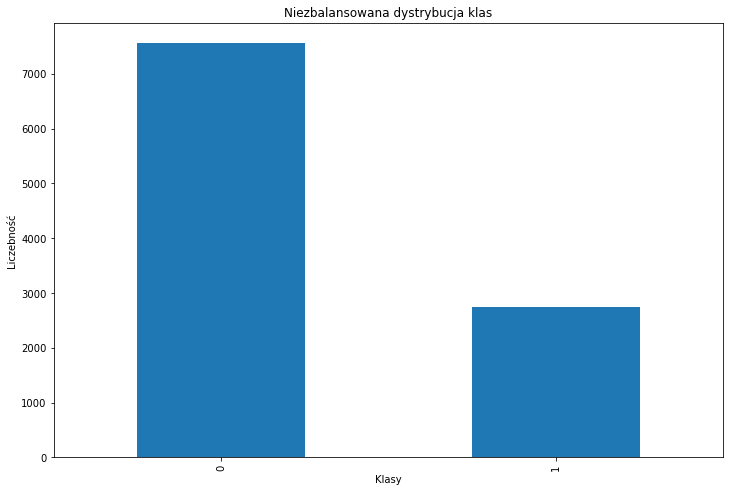

In [82]:
plt.figure(figsize=(12, 8))
df.CLAIM_FLAG.value_counts().nlargest(10).sort_values(ascending=False).plot.bar()
plt.title("Niezbalansowana dystrybucja klas")
plt.xlabel("Klasy")
plt.ylabel("Liczebność")

In [83]:
# standaryzacja
#df['INCOME'] = ((df['INCOME'] - df['INCOME'].mean()) / df['INCOME'].std())
#df['OLDCLAIM'] = ((df['OLDCLAIM'] - df['OLDCLAIM'].mean()) / df['OLDCLAIM'].std())
#df['CAR_AGE'] =( (df['CAR_AGE'] - df['CAR_AGE'].mean()) / df['CAR_AGE'].std())

In [84]:
#min max
#df['INCOME'] = (df['INCOME'] - df['INCOME'].min()) /  ( df['INCOME'].max() -  df['INCOME'].min())
#df['OLDCLAIM'] = (df['OLDCLAIM'] - df['OLDCLAIM'].min()) /  ( df['OLDCLAIM'].max() -  df['OLDCLAIM'].min())
#df['CAR_AGE'] =(df['CAR_AGE'] - df['CAR_AGE'].min()) / ( df['CAR_AGE'].max() -  df['CAR_AGE'].min())
#df.head()

In [85]:
col_list = ['CLAIM_FLAG','INCOME','CAR_AGE','AGE_GROUP','HOMEKIDS','MVR_PTS']
X = df[col_list]

In [88]:
# technika imputacji

imputer = KNNImputer(n_neighbors=15)
X_transformed = imputer.fit_transform(X)

m = 0
for col in col_list:
    df[col] = X_transformed[:,m]
    m+=1

In [89]:
w = df['CLAIM_FLAG'].value_counts() / df.shape[0]
w

0.0    0.73345
1.0    0.26655
Name: CLAIM_FLAG, dtype: float64

In [90]:
df['sample_weights'] = 0
df['sample_weights'][df['CLAIM_FLAG'] == 0] = w[1]
df['sample_weights'][df['CLAIM_FLAG'] == 1] = w[0]

In [91]:
df['Nrow'] = [x for x in range(df.shape[0])] 

In [92]:
ids = random.sample(list(df['Nrow'].values), int(.70*df.shape[0]))
df_train = df[df['Nrow'].isin(ids)]
df_test = df[~df['Nrow'].isin(ids)]

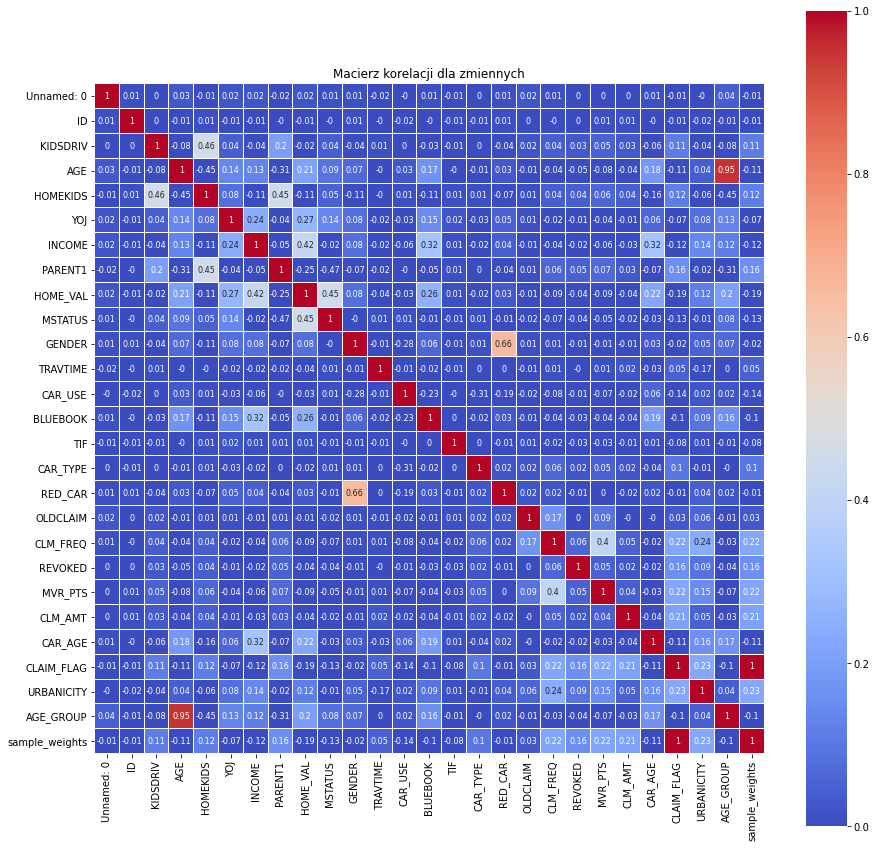

In [115]:
fig=plt.figure(figsize = (15, 15))
ax1 = fig.add_subplot(111)
corr = df.iloc[ : , : -1].corr().round(2)
sns.heatmap(corr, vmin = 0.0, vmax = 1, square=True, linewidths = 0.1, annot = True, annot_kws={"size" : 8}, cmap = "coolwarm")
plt.title("Macierz korelacji dla zmiennych")
plt.show()

MLE -  Maximum Likelihood Estimation

In [94]:
m1 = smf.logit(formula = 'CLAIM_FLAG ~ INCOME + CAR_AGE + AGE_GROUP + HOMEKIDS + MVR_PTS', data = df_train, sample_weight = df_train['sample_weights']).fit()

Optimization terminated successfully.
         Current function value: 0.544591
         Iterations 6


In [95]:
print(m1.summary().tables[0])

                           Logit Regression Results                           
Dep. Variable:             CLAIM_FLAG   No. Observations:                 7211
Model:                          Logit   Df Residuals:                     7205
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Jun 2022   Pseudo R-squ.:                 0.06115
Time:                        22:23:53   Log-Likelihood:                -3927.0
converged:                       True   LL-Null:                       -4182.8
Covariance Type:            nonrobust   LLR p-value:                2.500e-108


In [96]:
print(m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9026      0.133     -6.809      0.000      -1.162      -0.643
INCOME        -0.0037      0.001     -5.607      0.000      -0.005      -0.002
CAR_AGE       -0.0280      0.006     -5.020      0.000      -0.039      -0.017
AGE_GROUP     -0.0534      0.034     -1.568      0.117      -0.120       0.013
HOMEKIDS       0.1638      0.026      6.201      0.000       0.112       0.216
MVR_PTS        0.2036      0.012     16.792      0.000       0.180       0.227


In [107]:
p = 0.6
y_pred = m1.predict(df_test)
y_pred_kwant = y_pred.copy()

y_pred_kwant[y_pred_kwant >= p] = 1
y_pred_kwant[y_pred_kwant < p] = 0

In [108]:
print(confusion_matrix(df_test["CLAIM_FLAG"], y_pred_kwant.astype(np.int32)))

[[2247   22]
 [ 767   55]]


In [109]:
y_pred_kwant.unique()

array([0., 1.])

In [110]:
acc = round(accuracy_score(y_pred_kwant, df_test["CLAIM_FLAG"]),2)*100
b_acc = round(balanced_accuracy_score(y_pred_kwant,df_test["CLAIM_FLAG"]),2)*100

print(f'Dokładność wynosi {acc} %, ale bieda')
print(f'Zbalansowana dokładność wynosi {b_acc} %, żenada')

Dokładność wynosi 74.0 %, ale bieda
Zbalansowana dokładność wynosi 73.0 %, żenada


In [111]:
print(f'Area Under Curve: {roc_auc_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')
print(f'Recall score: {recall_score(y_pred_kwant, df_test["CLAIM_FLAG"])}')

Area Under Curve: 0.7299033083704616
Recall score: 0.7142857142857143


In [112]:
fpr, tpr, _ = roc_curve(df_test["CLAIM_FLAG"], y_pred)
roc_auc = auc(fpr, tpr)

No handles with labels found to put in legend.


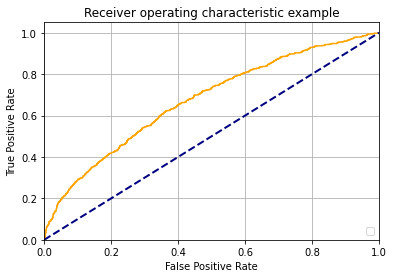

In [113]:
plt.figure()
lw = 2
plt.plot(fpr, tpr,color="orange")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.grid()
plt.show()

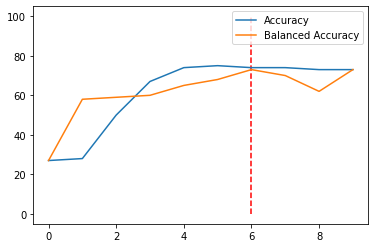

In [114]:
accl=[]
b_accl=[]
top = 10
for i in range(top):
    y_pred_kwant = y_pred.copy()
    y_pred_kwant[y_pred_kwant >= (i*0.1)] = 1
    y_pred_kwant[y_pred_kwant < (i*0.1)] = 0
    
    acc = round(accuracy_score(y_pred_kwant, df_test["CLAIM_FLAG"]),2)*100
    
    b_acc = round(balanced_accuracy_score(y_pred_kwant,df_test["CLAIM_FLAG"]),2)*100
    #print(f'Zbalansowana dokładność wynosi {b_acc} %')
    
    accl.append(acc)
    b_accl.append(b_acc)
    #print(f'{round(i*0.1)} Dokładność wynosi {acc} %')
    
plt.plot([*range(top)], accl, label = 'Accuracy')
plt.plot([*range(top)], b_accl,label = 'Balanced Accuracy' )
plt.legend()
plt.vlines(np.argmax(b_accl),0,100, color = 'red', ls='--')
plt.show()